In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')   

In [22]:
import dask.dataframe as dd

nyc_bike = dd.read_csv("Trips_2018.csv",  blocksize="256MB")

In [23]:
# Converting date & time
nyc_bike['starttime'] = dd.to_datetime(nyc_bike['starttime'], errors = 'coerce')
nyc_bike['stoptime'] = dd.to_datetime(nyc_bike['stoptime'], errors = 'coerce')
nyc_bike['starttime'].head()

# Extracting hour/day/month
nyc_bike['start_hour'] = nyc_bike['starttime'].dt.hour
nyc_bike['start_day'] = nyc_bike['starttime'].dt.dayofweek
nyc_bike['start_month'] = nyc_bike['starttime'].dt.month

MemoryError: 

In [ ]:
# 1) Remove duplicates (lazy, safe)
nyc_bike = nyc_bike.drop_duplicates()

# 2) Drop missing timestamps
nyc_bike = nyc_bike.dropna(subset=['starttime', 'stoptime'])

# 3) Compute trip duration (in seconds)
nyc_bike['duration'] = (nyc_bike['stoptime'] - nyc_bike['starttime']).dt.total_seconds()
# Remove trips with invalid duration (zero, negative, or missing)
nyc_bike = nyc_bike[nyc_bike['duration'] > 0]

# 5) Remove invalid or out-of-bound coordinates
nyc_bike = nyc_bike[
    (nyc_bike['start_station_latitude'].between(40, 41)) &
    (nyc_bike['start_station_longitude'].between(-74.3, -73.6)) &
    (nyc_bike['end_station_latitude'].between(40, 41)) &
    (nyc_bike['end_station_longitude'].between(-74.3, -73.6))
]

# 6) Optional: keep only valid user types
nyc_bike = nyc_bike[nyc_bike['usertype'].isin(['Customer', 'Subscriber'])]

# 7) Optional: remove super-long trips (>24 hours)
nyc_bike = nyc_bike[nyc_bike['duration'] < 24*3600]

# 8) Preview (safe compute)
nyc_bike.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour,start_day,start_month,duration
6,6,722,2018-01-02 07:54:53.646,2018-01-02 08:06:55.872,72.0,40.767272,-73.993929,228.0,40.754601,-73.971879,32059,Subscriber,1978,1,7,1,1,722.226
9,9,324,2018-01-02 08:13:30.896,2018-01-02 08:18:55.120,72.0,40.767272,-73.993929,450.0,40.762272,-73.987882,30892,Subscriber,1947,1,8,1,1,324.224
10,10,1155,2018-01-02 09:15:29.905,2018-01-02 09:34:45.020,72.0,40.767272,-73.993929,347.0,40.728846,-74.008591,31591,Subscriber,1982,1,9,1,1,1155.115
15,15,256,2018-01-02 13:54:11.646,2018-01-02 13:58:28.198,72.0,40.767272,-73.993929,514.0,40.760875,-74.002777,31095,Subscriber,1978,1,13,1,1,256.552
19,19,724,2018-01-02 15:25:00.541,2018-01-02 15:37:05.323,72.0,40.767272,-73.993929,490.0,40.751551,-73.993934,19512,Subscriber,1965,1,15,1,1,724.782


__Weekday and Hour heatmap__

In [ ]:
heatmap_data = (
    nyc_bike.groupby(['start_day', 'start_hour'])
            .size()
            .compute()
)

heatmap_df = heatmap_data.unstack(level=1)

day_map = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

heatmap_df.index = heatmap_df.index.map(day_map)
plt.figure(figsize=(14,6))
sns.heatmap(heatmap_df, cmap='viridis')
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.title("Trips by Hour and Weekday")
plt.show()

MemoryError: 

__Month and Hour Heatmap__

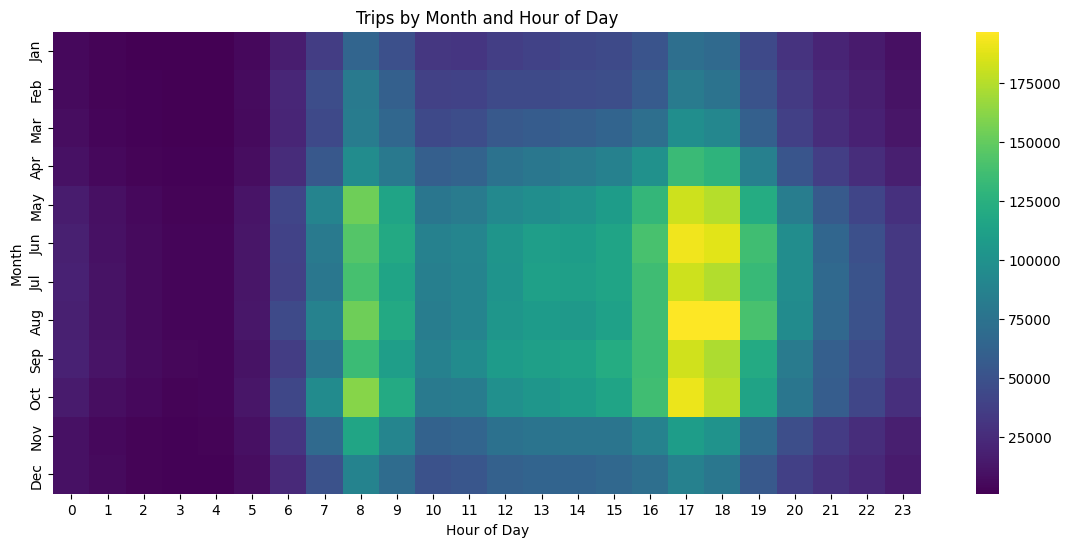

In [ ]:
month_hour = (
    nyc_bike.groupby(['start_month', 'start_hour'])
            .size()
            .compute()
)

month_hour_df = month_hour.unstack(level=1)

month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep",10: "Oct",11: "Nov",12: "Dec"
}

month_hour_df.index = month_hour_df.index.map(month_map)

plt.figure(figsize=(14,6))
sns.heatmap(month_hour_df, cmap="viridis")
plt.title("Trips by Month and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Month")
plt.show()

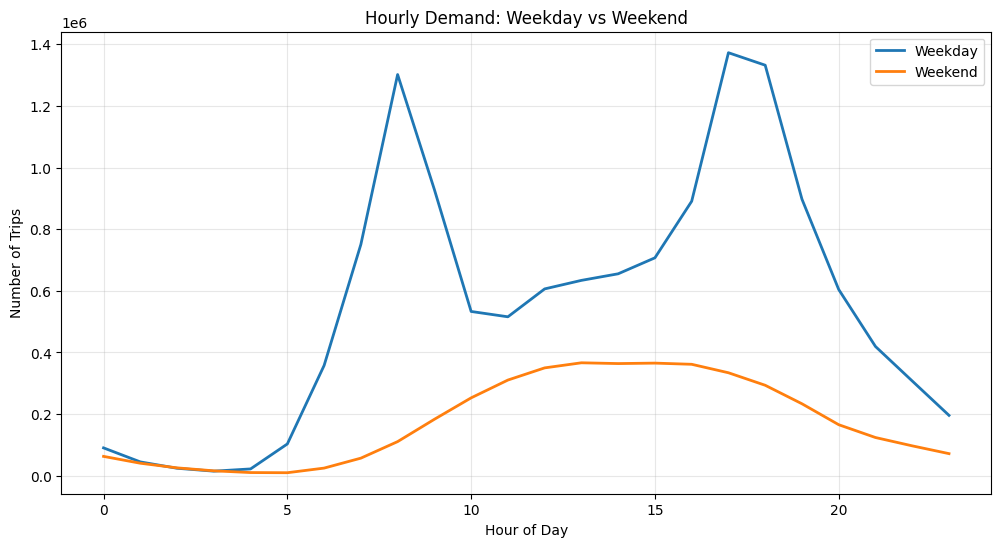

In [ ]:
# Weekend vs Weekday Curves

weekday = nyc_bike[nyc_bike['start_day'] < 5]
weekend = nyc_bike[nyc_bike['start_day'] >= 5]

weekday_curve = weekday.groupby('start_hour').size().compute().sort_index()
weekend_curve = weekend.groupby('start_hour').size().compute().sort_index()

plt.figure(figsize=(12,6))
plt.plot(weekday_curve.index, weekday_curve.values, label='Weekday', linewidth=2)
plt.plot(weekend_curve.index, weekend_curve.values, label='Weekend', linewidth=2)

plt.title('Hourly Demand: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

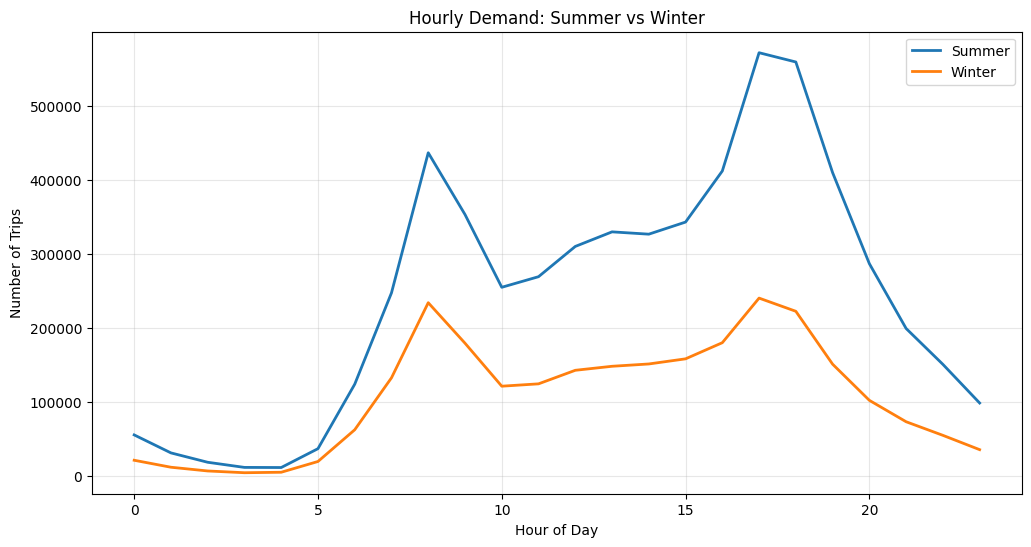

In [ ]:
# Summer vs Winter curve

summer = nyc_bike[nyc_bike['start_month'].isin([6, 7, 8])]
winter = nyc_bike[nyc_bike['start_month'].isin([12, 1, 2])]

summer_curve = summer.groupby('start_hour').size().compute().sort_index()
winter_curve = winter.groupby('start_hour').size().compute().sort_index()

plt.figure(figsize=(12,6))
plt.plot(summer_curve.index, summer_curve.values, label='Summer', linewidth=2)
plt.plot(winter_curve.index, winter_curve.values, label='Winter', linewidth=2)

plt.title('Hourly Demand: Summer vs Winter')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Picking up some stations

# Get unique stations with their coordinates
stations = nyc_bike[['start_station_id', 'start_station_latitude', 'start_station_longitude']] \
            .dropna() \
            .drop_duplicates() \
            .compute()

# BUSINESS DISTRICT (Manhattan: Midtown + FiDi)
business_zone = stations[
    (stations['start_station_latitude'].between(40.70, 40.77)) &
    (stations['start_station_longitude'].between(-74.00, -73.97))
]

# RESIDENTIAL (Brooklyn: Cobble Hill, Clinton Hill, Williamsburg)
residential_zone = stations[
    (stations['start_station_latitude'].between(40.69, 40.78)) &
    (stations['start_station_longitude'].between(-74.02, -73.93))
]

# RECREATIONAL (Waterfront + parks: Central Park + Brooklyn Bridge Park)
recreational_zone = stations[
    (stations['start_station_latitude'].between(40.68, 40.73)) &
    (stations['start_station_longitude'].between(-74.02, -74.00))
]

In [ ]:
def top_busiest(n, zone):
    station_ids = zone['start_station_id'].unique()

    counts = (
        nyc_bike[nyc_bike['start_station_id'].isin(station_ids)]
        .groupby('start_station_id')
        .size()
        .compute()
        .sort_values(ascending=False)
        .head(n)
    )

    return counts

In [ ]:
top3_business = top_busiest(3, business_zone)
top3_residential = top_busiest(3, residential_zone)
top3_recreational = top_busiest(3, recreational_zone)

top3_business, top3_residential, top3_recreational

(start_station_id
 519.0    150246
 497.0    108865
 435.0    107154
 dtype: int64,
 start_station_id
 519.0    150246
 497.0    108865
 435.0    107154
 dtype: int64,
 start_station_id
 426.0     94453
 3002.0    76852
 387.0     70755
 dtype: int64)

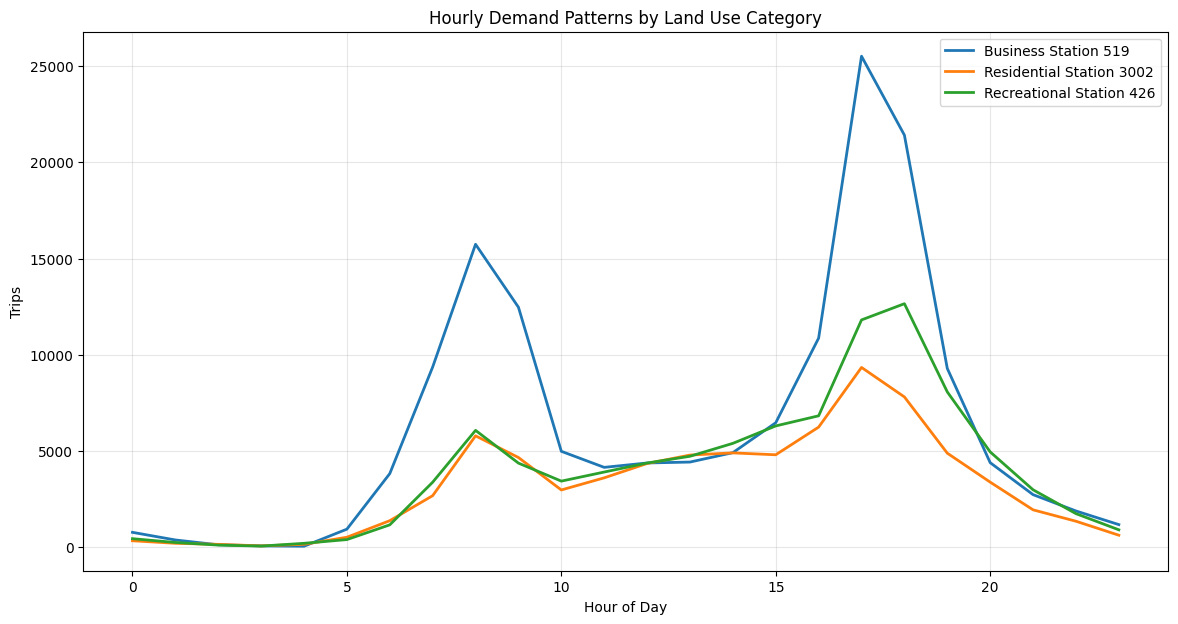

In [ ]:
def hourly_curve(station_id):
    data = nyc_bike[nyc_bike['start_station_id'] == station_id]
    hourly = data.groupby('start_hour').size().compute().sort_index()
    return hourly

business_curve = hourly_curve(519)
residential_curve = hourly_curve(3002)
recreational_curve = hourly_curve(426)

plt.figure(figsize=(14,7))
plt.plot(business_curve.index, business_curve.values, label='Business Station 519', linewidth=2)
plt.plot(residential_curve.index, residential_curve.values, label='Residential Station 3002', linewidth=2)
plt.plot(recreational_curve.index, recreational_curve.values, label='Recreational Station 426', linewidth=2)

plt.title('Hourly Demand Patterns by Land Use Category')
plt.xlabel('Hour of Day')
plt.ylabel('Trips')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
def hourly_counts_for(station_id):
    return (
        nyc_bike[nyc_bike['start_station_id'] == station_id]
        .groupby('start_hour')
        .size()
    )

business = hourly_counts_for(519).compute()
residential = hourly_counts_for(3002).compute()
recreational = hourly_counts_for(426).compute()

df = pd.DataFrame({
    'Business': business,
    'Residential': residential,
    'Recreational': recreational
}).fillna(0)

df_pct = df.div(df.sum(axis=1), axis=0)

df_pct.plot.area(figsize=(12,7), alpha=0.6)
plt.title("Hourly Share of Demand by Land-Use Category")
plt.xlabel("Hour")
plt.ylabel("Share of Trips")
plt.show()

KeyboardInterrupt: 

In [ ]:
# Cluster Finisher

# 1) Keep only relevant columns
reduced = nyc_bike[['start_station_id', 'start_hour']]

# 2) Count trips per (station, hour)
counts = (
    reduced
    .groupby(['start_station_id', 'start_hour'])
    .size()
    .compute()
    .reset_index(name='trips')
)

counts.head()

,start_station_id,start_hour,trips
0,72.0,0,335
1,72.0,1,240
2,72.0,2,165
3,72.0,3,84
4,72.0,4,117


In [ ]:
hourly_matrix = counts.pivot_table(
    index='start_station_id',
    columns='start_hour',
    values='trips',
    fill_value=0
)

hourly_matrix.head()

start_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
start_station_id,,,,,,,,,,,,,,,,,,,,,
72.0,335.0,240.0,165.0,84.0,117.0,273.0,510.0,1714.0,3383.0,2969.0,...,2144.0,2281.0,2762.0,3466.0,3496.0,2588.0,1535.0,915.0,800.0,565.0
79.0,229.0,119.0,58.0,30.0,18.0,122.0,272.0,491.0,1542.0,1401.0,...,1695.0,1702.0,2079.0,2903.0,3551.0,2248.0,1241.0,835.0,503.0,380.0
82.0,63.0,40.0,26.0,11.0,9.0,37.0,411.0,387.0,543.0,830.0,...,637.0,662.0,719.0,862.0,873.0,701.0,494.0,311.0,179.0,115.0
83.0,156.0,92.0,37.0,24.0,14.0,20.0,278.0,339.0,385.0,372.0,...,797.0,839.0,901.0,1167.0,1423.0,1181.0,859.0,711.0,580.0,429.0
119.0,8.0,15.0,10.0,5.0,15.0,33.0,170.0,168.0,312.0,250.0,...,226.0,185.0,228.0,243.0,195.0,194.0,119.0,70.0,52.0,26.0


In [ ]:
hourly_matrix = hourly_matrix[hourly_matrix.sum(axis=1) > 5000]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(hourly_matrix)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X)

hourly_matrix['cluster'] = clusters

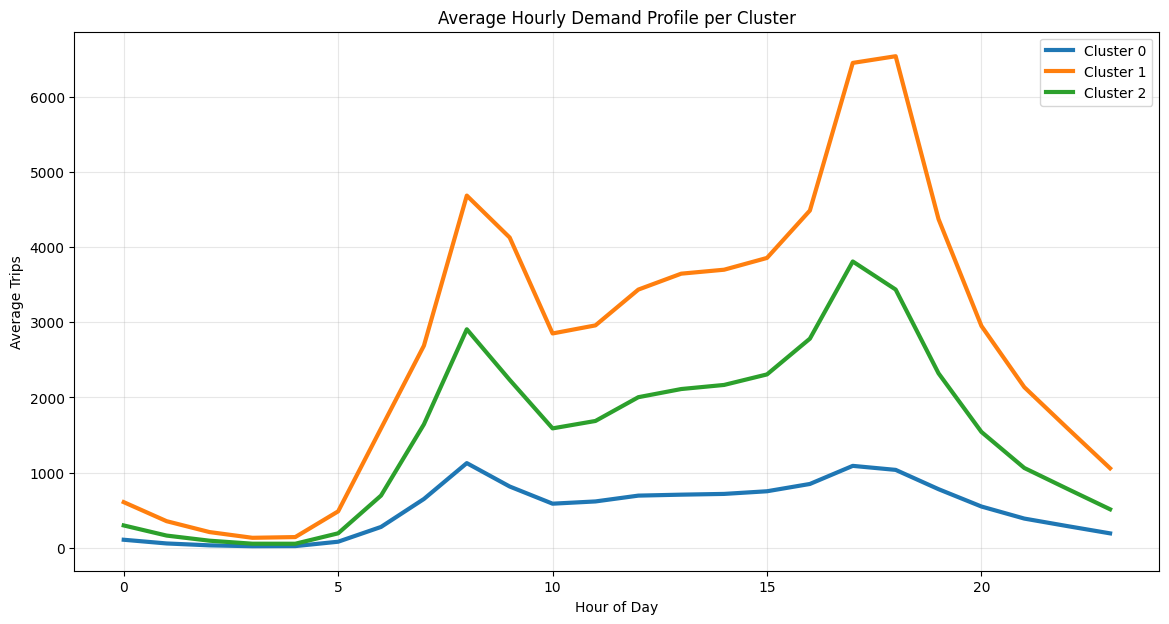

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

for c in range(3):
    mean_profile = hourly_matrix[hourly_matrix['cluster'] == c].iloc[:,:24].mean()
    plt.plot(mean_profile.index, mean_profile.values, linewidth=3, label=f'Cluster {c}')

plt.legend()
plt.title("Average Hourly Demand Profile per Cluster")
plt.xlabel("Hour of Day")
plt.ylabel("Average Trips")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Merge station coordinates with cluster labels
clustered_stations = stations.merge(
    hourly_matrix['cluster'],
    left_on='start_station_id',
    right_index=True,
    how='inner'
)

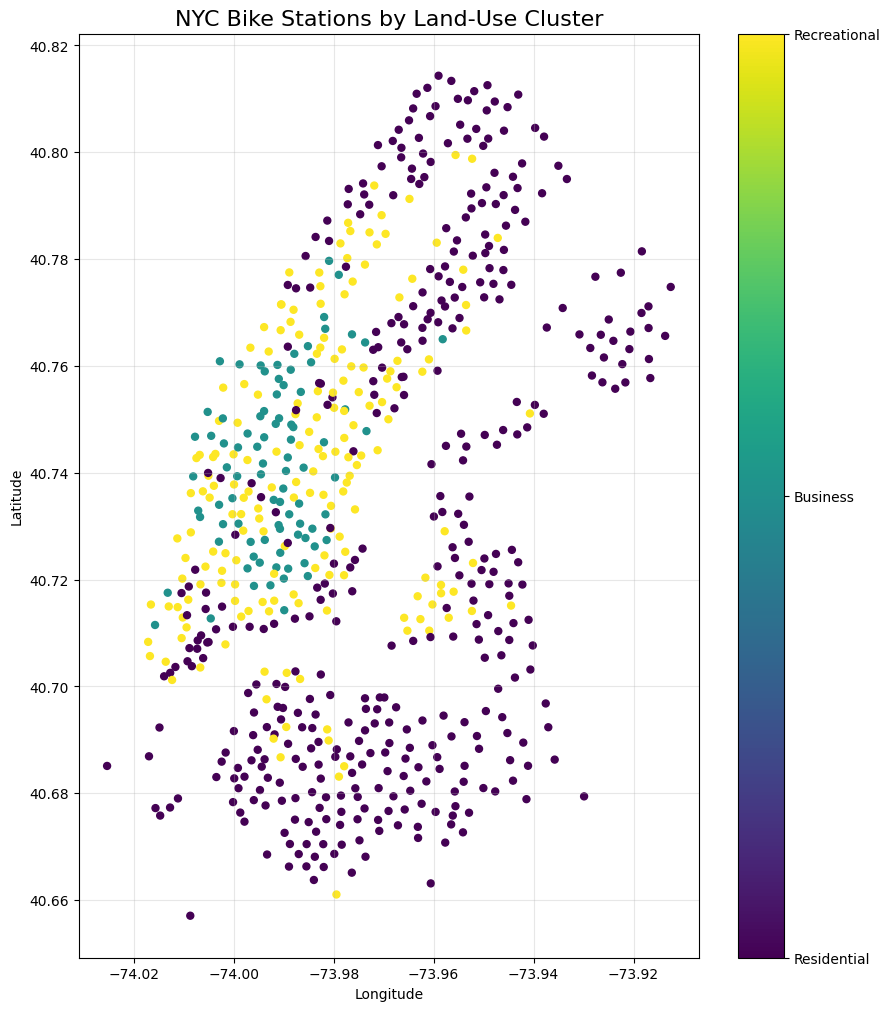

In [ ]:
label_map = {0: "Residential", 1: "Business", 2: "Recreational"}
clustered_stations['label'] = clustered_stations['cluster'].map(label_map)

plt.figure(figsize=(10, 12))

scatter = plt.scatter(
    clustered_stations['start_station_longitude'],
    clustered_stations['start_station_latitude'],
    c=clustered_stations['cluster'],
    cmap='viridis',
    s=25
)

plt.title("NYC Bike Stations by Land-Use Cluster", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

cbar = plt.colorbar(scatter)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(["Residential", "Business", "Recreational"])

plt.grid(alpha=0.3)
plt.show()


   TRAINING STATION 519

---- Random Forest Performance ----
MAE: 3.327587599802716
RMSE: 5.105958289511253
R²: 0.6728624650128874

---- Baseline (lag_1) ----
Baseline MAE: 7.109365179132621
Baseline RMSE: 11.212842820765525


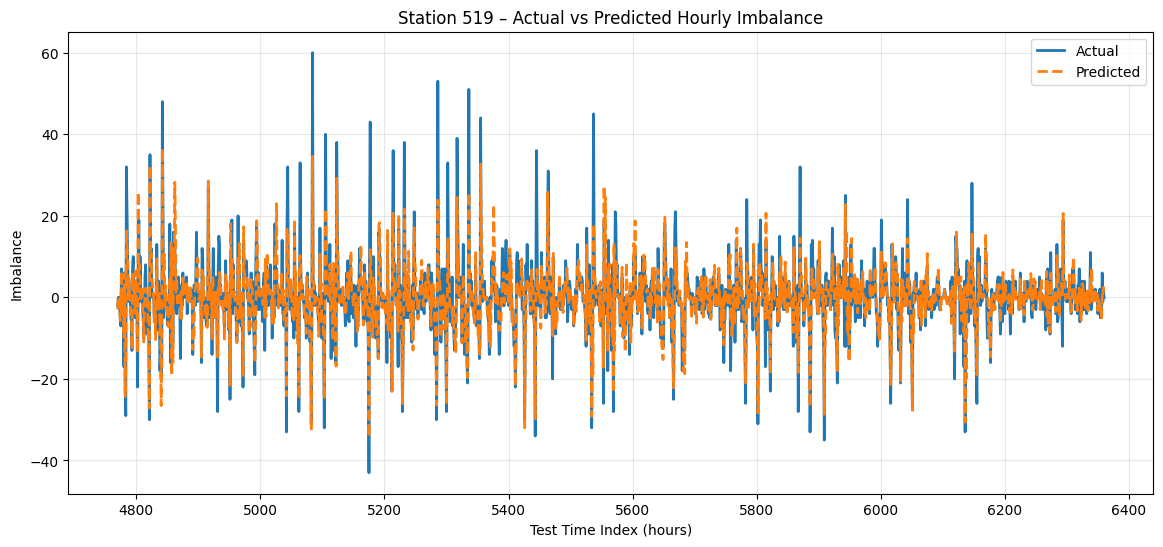


   TRAINING STATION 3002

---- Random Forest Performance ----
MAE: 2.4671947277577706
RMSE: 3.4302753174794622
R²: 0.4498815465956867

---- Baseline (lag_1) ----
Baseline MAE: 4.9858757062146895
Baseline RMSE: 7.0178344238090995


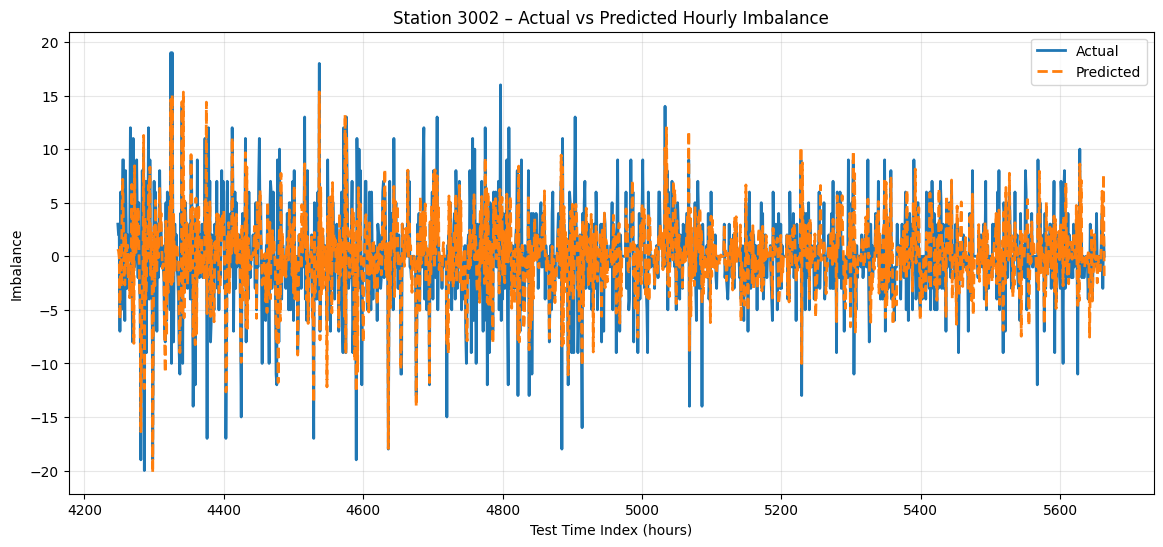


   TRAINING STATION 426

---- Random Forest Performance ----
MAE: 2.9178575067974144
RMSE: 4.24284420104204
R²: 0.7464292280461744

---- Baseline (lag_1) ----
Baseline MAE: 5.716244002741604
Baseline RMSE: 8.619518154428965


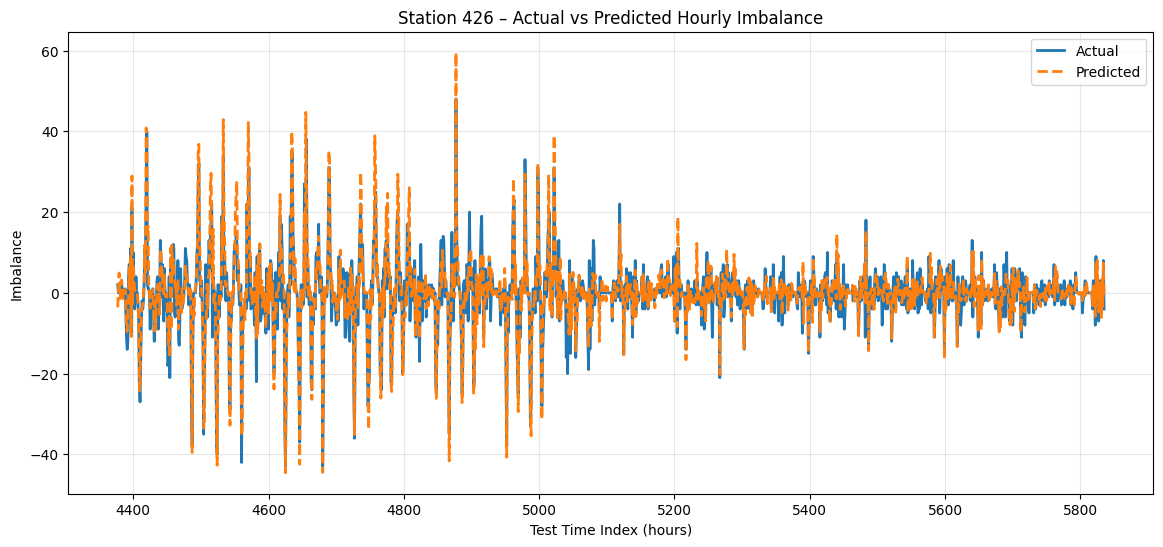


===== SUMMARY FOR ALL 3 STATIONS =====

   station       mae      rmse        r2  baseline_mae  baseline_rmse
0      519  3.327588  5.105958  0.672862      7.109365      11.212843
1     3002  2.467195  3.430275  0.449882      4.985876       7.017834
2      426  2.917858  4.242844  0.746429      5.716244       8.619518


In [ ]:
# Some ML work to see if I can better predict the imbalance

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# FUNCTION: Train + Evaluate One Station

def train_station_model(station_id):

    print(f'Training Station Nr {station_id}')

    # 1) Filter this station (starts or ends)
    station_df = nyc_bike[
        (nyc_bike['start_station_id'] == station_id) |
        (nyc_bike['end_station_id'] == station_id)
    ].compute()

    # 2) Extract date and hour
    station_df['date'] = station_df['starttime'].dt.date
    station_df['hour'] = station_df['starttime'].dt.hour

    # 3) Count hourly starts/ends
    starts = station_df[station_df['start_station_id'] == station_id] \
                .groupby(['date', 'hour']).size()

    ends = station_df[station_df['end_station_id'] == station_id] \
                .groupby(['date', 'hour']).size()

    # 4) Imbalance
    hourly = (starts - ends).rename("imbalance").to_frame()

    # 5) Ensure all hours exist
    all_dates = hourly.index.get_level_values(0).unique()
    full_index = pd.MultiIndex.from_product(
        [all_dates, range(24)], names=['date', 'hour']
    )

    hourly = hourly.reindex(full_index, fill_value=0)

    # 6) Lag features
    hourly['lag_1'] = hourly['imbalance'].shift(1)
    hourly['lag_24'] = hourly['imbalance'].shift(24)
    hourly['ma_3'] = hourly['imbalance'].rolling(window=3).mean()

    hourly = hourly.dropna().reset_index()

    # 7) Features + Target
    X = hourly[['hour', 'lag_1', 'lag_24', 'ma_3']]
    y = hourly['imbalance']

    # 8) Time-split 75/25
    split_point = int(len(X) * 0.75)
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

    # 9) Model
    model = RandomForestRegressor(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)

    # 10) Predictions
    pred = model.predict(X_test)
    baseline = X_test['lag_1']

    # 11) Metrics
    mae  = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2   = r2_score(y_test, pred)

    baseline_mae  = mean_absolute_error(y_test, baseline)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline))

    print("---- Random Forest Performance ----")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R²:", r2)
    print()
    print("---- Baseline (lag_1) ----")
    print("Baseline MAE:", baseline_mae)
    print("Baseline RMSE:", baseline_rmse)

    # 12) Plot
    plt.figure(figsize=(14,6))
    plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
    plt.plot(y_test.index, pred, label="Predicted", linestyle='--', linewidth=2)
    plt.title(f"Station {station_id} – Actual vs Predicted Hourly Imbalance")
    plt.xlabel("Test Time Index (hours)")
    plt.ylabel("Imbalance")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return {
        "station": station_id,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "baseline_mae": baseline_mae,
        "baseline_rmse": baseline_rmse
    }

stations = [519, 3002, 426]   # Business, Residential, Recreational

results = []

for s in stations:
    metrics = train_station_model(s)
    results.append(metrics)

# Print Summary Table
summary = pd.DataFrame(results)
print("Summary for all 3 stations")
print(summary)
